In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
from catboost import CatBoostRegressor
from scipy.linalg import eigh
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import curve_fit


In [ ]:
def results (m1, m2, m3, k1, k2, k3, h, T_RS, dispRS, velRS, accelRS, eqfile):
    K = np.array([
            [k1 + k2, -k2, 0],
            [-k2, k2 + k3, -k3],
            [0, -k3, k3]
        ])
    M = np.array([
            [m1, 0, 0],
            [0, m2, 0],
            [0, 0, m3]
        ])

    eigvals, eigvecs = eigh(K, M)  # Solves the generalized eigenvalue problem
    omega = np.sqrt(eigvals)
    # Time periods (s)
    T = 2 * np.pi / omega
    T_sorted = np.sort(T)[::-1]
    T1 = T_sorted[0]
    T2 = T_sorted[1]
    T3 = T_sorted[2]

    ground_accel = np.loadtxt(eqfile) * 9.81 # Load ground acceleration data from the earthquake file
    dt = np.loadtxt("dt.txt")                # Load the time step from dt.tx
    sd = significant_duration(ground_accel, dt[int(eqfile[2:-4])], start_pct=5, end_pct=95)
    pf = get_predominant_frequency(ground_accel, dt[int(eqfile[2:-4])])
    max_pga_g = np.max(np.abs(ground_accel)) /9.81 # Maximum PGA in g
    f = interp1d(T_RS, accelRS, kind='linear', fill_value="extrapolate", bounds_error=False)
    fd = interp1d(T_RS,dispRS,kind='linear', fill_value="extrapolate", bounds_error=False)
    fv = interp1d(T_RS,velRS,kind='linear', fill_value="extrapolate", bounds_error=False)

    Sa_t1 = f(T1)
    Sa_t2 = f(T2)
    Sa_t3 = f(T3)
    Sd_t1 = fd(T1)
    Sd_t2 = fd(T2)
    Sd_t3 = fd(T3)
    Sv_t1 = fv(T1)
    Sv_t2 = fv(T2)
    Sv_t3 = fv(T3)

    data = pd.DataFrame([{
        '[m1]': m1,
        '[m2]': m2,
        '[m3]': m3,
        '[k1]': k1,
        '[k2]': k2,
        '[k3]': k3,
        '[T1]': T1,
        '[T2]': T2,
        '[T3]': T3,
        'EQ_Duration': sd,
        'Freq_Predominant': pf,
        'pga_max(g)': max_pga_g,    
        'Sa_t1': Sa_t1,
        'Sa_t2': Sa_t2,
        'Sa_t3': Sa_t3,
        'Sd_t1': Sd_t1,
        'Sd_t2': Sd_t2,
        'Sd_t3': Sd_t3,
        'Sv_t1': Sv_t1,
        'Sv_t2': Sv_t2,
        'Sv_t3': Sv_t3
    }])

    # Load CatBoost Models
    cbmodels = []
    for i in range(2) :
        model = CatBoostRegressor()
        model.load_model(f"cbmodel_{i}.cbm")
        cbmodels.append(model)

    if T1 < 2 :
        y_preds = []
        for i in range(2):
            y_pred = cbmodels[i].predict(data)
            y_preds.append(y_pred)

        final_prediction = np.column_stack(y_preds)  # shape: (n_samples, 2) # First column: Roof Disp. in m, Second column: IDR
        if h != 3:
            final_prediction[0][1] = final_prediction[0][1]*(3/h) # Adjust IDR based on storey height
            print(f"Roof Displacement: {final_prediction[0, 0]:.2f} m, MaxIDR: {final_prediction[0, 1]:.2f}")
        
        return final_prediction[0, 0], final_prediction[0, 1], Sd_t1  
    else : 
        print(f"T1 is {T1.round(2)} sec, it should be less than 2 sec. Select different mass and stiffness parameters")
        return None, None, None

In [ ]:
# Predict using loaded models

# mass_range=(5000, 50000) in kg, Stiffness range=(1e5, 1e8) in N/m, Select paramers in these ranges only
# Damping = 5%, which can not be changed

# Input parameters  -----------------------------------------------------------------
m1 = 15000
m2 = 15000
m3 = 15000
k1 = 1e7
k2 = 1e7
k3 = 1e7
h = 3                 # Storey height in m
eqfile = "TH0.txt"    # Select the earthquake file (from TH0 to TH21, taken from PEERNGA WEST database)

# ----------------------------------------------------------------------------------
dt = np.loadtxt("dt.txt")
beta = 0.25   # Average acceleration method
gamma = 0.5   # Average acceleration method
damping_ratio = 0.05  # 5% damping
ground_accel = np.loadtxt(eqfile) * 9.81
T_RS, dispRS, velRS, accelRS = RS(dt[int(eqfile[2:-4])], beta, gamma, damping_ratio, ground_accel)
roof_disp, max_idr, Sd_T1 = results(m1, m2, m3, k1, k2, k3, h, T_RS, dispRS, velRS, accelRS, eqfile)
if roof_disp is not None and max_idr is not None:
    print(f"Roof Displacement: {roof_disp:.2f} m, Max IDR: {max_idr*100:.2f}%")

Roof Displacement: 0.13 m, Max IDR: 2.64%


Development of fragility curve

In [ ]:
# Loading the mass and stiffness parameters from a CSV file with first mode time period less than 2 seconds
df1 = pd.read_csv("mass_stiffness.csv")
df = df1.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,[m1],[m2],[m3],[k1],[k2],[k3]
0,24430,25515,5886,1.312248e+09,7.223371e+06,1.415281e+09
1,22681,6771,13150,3.070678e+07,3.332694e+05,1.472126e+06
2,11632,15235,46586,2.866967e+09,2.255187e+09,8.858818e+07
3,20080,21927,31165,8.028671e+05,7.140429e+06,5.902171e+07
4,5067,16914,22469,8.810534e+06,2.272282e+06,2.416095e+06


In [29]:
topdisp = []
max_idr = []
Sd_T1 = []
dt = np.loadtxt("dt.txt")
h = 3                 # Storey height in m

for i in range(21) :
    eqfile = "TH" + str(i) + ".txt"    # Select the earthquake file (from TH0 to TH21, taken from PEERNGA WEST database)
    beta = 0.25   # Average acceleration method
    gamma = 0.5   # Average acceleration method
    damping_ratio = 0.05  # 5% damping
    ground_accel = np.loadtxt(eqfile) * 9.81
    T_RS, dispRS, velRS, accelRS = RS(dt[int(eqfile[2:-4])], beta, gamma, damping_ratio, ground_accel)
    for j in range (400):     # First 400 samples selected from dataframe, df
        m1 = df['[m1]'][j]
        m2 = df['[m2]'][j]
        m3 = df['[m3]'][j]
        k1 = df['[k1]'][j]
        k2 = df['[k2]'][j]
        k3 = df['[k3]'][j]
        
        roof_disp, idr, sdT1 = results(m1, m2, m3, k1, k2, k3, h, T_RS, dispRS, velRS, accelRS,eqfile)
        topdisp.append(roof_disp)
        max_idr.append(idr)
        Sd_T1.append(sdT1)
        

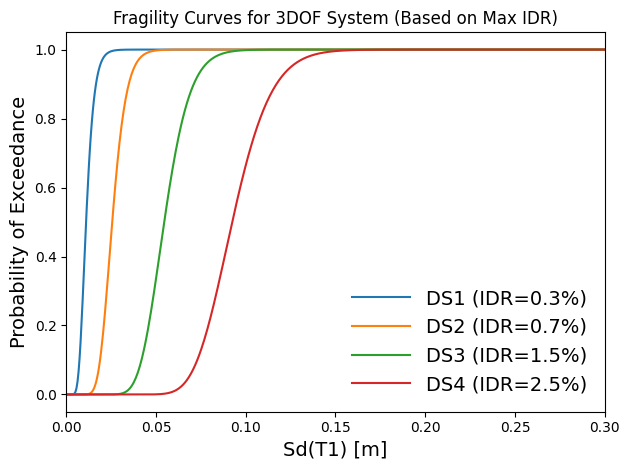

In [37]:
Sd_T1 = np.array(Sd_T1)
max_idr = np.array(max_idr)
topdisp = np.array(topdisp)
ds_limits = {
    'DS1': 0.003,   # Slight
    'DS2': 0.007,   # Moderate
    'DS3': 0.015,   # Extensive
    'DS4': 0.025,    # Collapse
}

def lognormal(pga, median, beta, eps=1e-6):
    return norm.cdf((np.log((pga + eps) / (median + eps))) / beta)

pga_vals = np.linspace(Sd_T1.min(), Sd_T1.max(), 600)
fragility_results = []

for label, limit in ds_limits.items():
    exceed = (max_idr >= limit).astype(int)
    p0 = [np.median(Sd_T1), 0.4]
    popt, _ = curve_fit(lognormal, Sd_T1, exceed, p0=p0, bounds=([0, 0.05], [np.inf, 1.5]))
    median, beta = popt
    prob_vals = lognormal(pga_vals, median, beta)
    plt.plot(pga_vals, prob_vals, label=f'{label} (IDR={100*limit:.1f}%)')
    fragility_results.append({'Damage State': label, 'Median Sd(T1)': median, 'Beta': beta})

plt.xlabel('Sd(T1) [m]', fontsize=14)
plt.ylabel('Probability of Exceedance', fontsize=14)
plt.title('Fragility Curves for 3DOF System (Based on Max IDR)', fontsize=12)
plt.tick_params(axis='both', labelsize=10)
plt.legend(prop={'size': 14}, handlelength=3, fancybox=True, framealpha=0)
plt.xlim(0,0.3)
plt.tight_layout()
plt.show()